In [2]:
from kitti_detection import config
from kitti_detection.dataset import DataSample, class_names, load_train_val_test_dataset
from kitti_detection.utils import display_samples_h

import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.tv_tensors import BoundingBoxes
from torchvision.ops.roi_pool import RoIPool

In [3]:
transforms = v2.Compose([
    v2.RandomCrop(size=(370, 370)),
    v2.SanitizeBoundingBoxes(),    
])

In [4]:
train_dataset, val_dataset, test_dataset = load_train_val_test_dataset()

train_dataset.transform = transforms

In [5]:
n_classes = len(class_names)

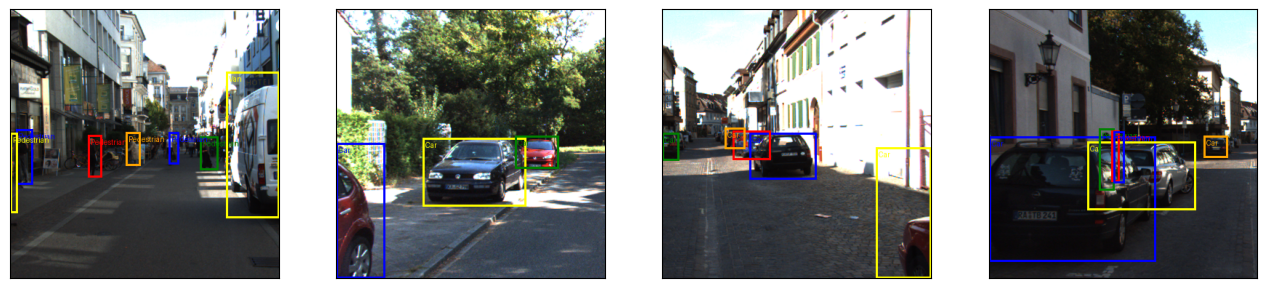

In [6]:
data_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
display_samples_h([next(iter(data_loader)) for _ in range(4)])

In [8]:
class FastRCNN(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.conv = None # TODO conv net, see 2.2
        self.roi_pool = RoIPool(output_size=(7, 7), spatial_scale=1.0) # TODO spatial_scale
        self.fc = nn.Sequential([
            nn.Linear() # TODO
        ])
        self.classifier = nn.Linear(out_features=n_classes + 1)
        self.bbox_regressor = nn.Linear(out_features=4)

    def forward(self, x):
        # Model input: tuple of 1. single image tensor 2. BoundingBoxes tensor of region proposal ROIs

        img, rois = x

        fmap = self.conv(img)
        windows = self.roi_pool(fmap, boxes=rois)
        windows = torch.flatten(windows, start_dim=1)

        pred_classes = self.classifier(windows)
        pred_bboxes = self.bbox_regressor(windows)
        
        return pred_classes, pred_bboxes



In [ ]:
# See 2.1 / Multi task loss

class MultiTaskLoss(nn.Module):

    def __init__(self, classification_weights = None, lmbd=1.0) -> None:
        self.classification_weights = classification_weights
        self.lmbd = lmbd
        pass

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        input_class, input_bbox = input
        target_class, target_bbox = target
        cls_loss = nn.functional.cross_entropy(input_class, target_class)

        c = None # [u > 1] factor (tensor)
        loc_loss = None # TODO use nn.SoftL1Loss and sum()

        return cls_loss + self.lmbd * c * loc_loss

In [ ]:
TRAIN_ROI_PROPOSALS = 64

In [ ]:
def generate_roi_proposals(img) -> BoundingBoxes:
    # input: image
    # output: ROI proposals (all of them)
    pass

In [ ]:
def generate_training_samples(ground_truth: DataSample) -> tuple[BoundingBoxes, Tensor, Tensor]:
    # input: DataSample containing image and ground truth labels
    # output: tuple of 1. ROI proposals 2. target classes 3. target bounding box corrections
    #         each are tensors of shape (TRAINING_ROI_PROPOSALS, ...)
    pass

In [ ]:
def train_model(model: nn.Module,
                device: str,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                batch_size: int,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                epochs: int):
    num_samples = len(train_loader.dataset)
    num_batches = len(train_loader)

    for epoch in range(epochs):
        
        # train
        model = model.train()
        train_loss = 0.0
        for idx, sample in enumerate(train_loader):
            img = sample[0]
            roi, target_class, target_bbox_corr = generate_training_samples(sample)

            X = (img, roi)
            Y = (target_class, target_bbox_corr)
            pred = model(X)
            
            loss = loss_fn(pred, Y)

            # Backpropagation
            loss.backward() # TODO backprop after two images?
            optimizer.step()
            optimizer.zero_grad()

            loss = loss.item()
            train_loss += loss
            print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f}  [{idx:>5d}/{num_samples:>5d}]', end='\r')
            
        train_loss /= num_batches

        # validate
        # TODO

        print(f'[{epoch + 1:>2}/{epochs}]: {train_loss=:5f} {val_loss=:5.5f} {val_accuracy=:2.1%}')